In [15]:
from game import Game
from player import Player
from plotter import Plotter


n_players = 5
# 7 type is minimax
player_types = [7 for p in range(n_players)]

In [16]:
game = Game(map="USA", player_types=player_types, players_num=len(player_types))
game.start()

In [17]:
game.player_turn

0

In [18]:
game.json()['state']

{0: {'Alaska': 1,
  'Vermont': 3,
  'Oregon': 2,
  'Arizona': 2,
  'Texas': 2,
  'Iowa': 2,
  'New Mexico': 1,
  'Indiana': 2,
  'Florida': 2,
  'New Hampshire': 1,
  'Ohio': 2},
 1: {'Connecticut': 1,
  'Kentucky': 2,
  'Michigan': 2,
  'Arkansas': 1,
  'California': 1,
  'Montana': 2,
  'New York': 3,
  'Illinois': 1,
  'Louisiana': 4,
  'Wyoming': 3},
 2: {'North Dakota': 3,
  'Oklahoma': 3,
  'Virginia': 1,
  'Delaware': 3,
  'South Dakota': 2,
  'West Virginia': 2,
  'Nevada': 1,
  'Georgia': 2,
  'Idaho': 3},
 3: {'New Jersey': 3,
  'Rhode Island': 2,
  'Pennsylvania': 1,
  'Hawaii': 2,
  'Massachusetts': 3,
  'Maryland': 1,
  'Nebraska': 2,
  'Kansas': 1,
  'Wisconsin': 1,
  'Minnesota': 1,
  'Washington': 2,
  'Mississippi': 1},
 4: {'Alabama': 3,
  'Maine': 2,
  'Tennessee': 3,
  'South Carolina': 5,
  'North Carolina': 3,
  'Utah': 2,
  'Missouri': 1,
  'Colorado': 1},
 -1: {}}

In [37]:
game.players

 None,

In [19]:
%matplotlib inline

In [79]:
PLAYER_COLORS = {
    -1: 'lightgray',  # Light gray for neutral
    0: 'lightblue',   
    1: 'lightpink', 
    2: 'lightgreen',
    3: 'lightyellow',
    4: 'lightsalmon',
    5: 'lightcoral',
    6: 'lightcyan',    # Light cyan for player 6
    7: 'mediumpurple',    # Light pink for player 7
}

In [87]:
from collections import defaultdict


def count_edges_between_owners(G, player_colors=PLAYER_COLORS):
    owner_edge_counts = defaultdict(int)

    for u, v in G.edges():
        owner_u = G.nodes[u].get('owner')
        owner_v = G.nodes[v].get('owner')

        if owner_u is not None and owner_v is not None and owner_u != owner_v and -1 not in [owner_u, owner_v]:
            owner_edge_counts[(player_colors[owner_u], player_colors[owner_v])] += 1
            owner_edge_counts[(player_colors[owner_v], player_colors[owner_u])] += 1

    return owner_edge_counts


def remove_duplicates_from_dict(d, filter_by_player=None, player_colors=PLAYER_COLORS):
    sorted_dict = {}
    for key, value in d.items():
        if filter_by_player is not None and player_colors[filter_by_player] not in key:
            continue
        sorted_key = tuple(sorted(key))
        if sorted_key in sorted_dict and sorted_dict[sorted_key] != value:
            raise ValueError("Cannot remove duplicates with different values from a directed graph.")
        sorted_dict[sorted_key] = value
    return sorted_dict


#remove_duplicates_from_dict(count_edges_between_owners(G))

In [120]:
import numpy as np
from scipy.stats import spearmanr, pearsonr


def get_edges_df(player, shared_edges):
    data = {}
    for edge, n_edges in shared_edges.items():
        edge_other_player = [p for p in edge if p != player][0]
        data[edge_other_player] = n_edges
    
    return pd.Series(data)


def calculate_and_sort_spearman_corr(int_data, float_data):
    int_data = int_data.sort_index()
    float_data = float_data.sort_index()
    # Calculate Spearman correlation
    spearman_corr, _ = pearsonr(int_data, float_data)

    return spearman_corr

simulation 0
compute for depth 0
lightblue plays!
{'move_type': 'reinforce', 'territory': 'Idaho', 'troops': 9}


AttributeError: 'NoneType' object has no attribute 'id'

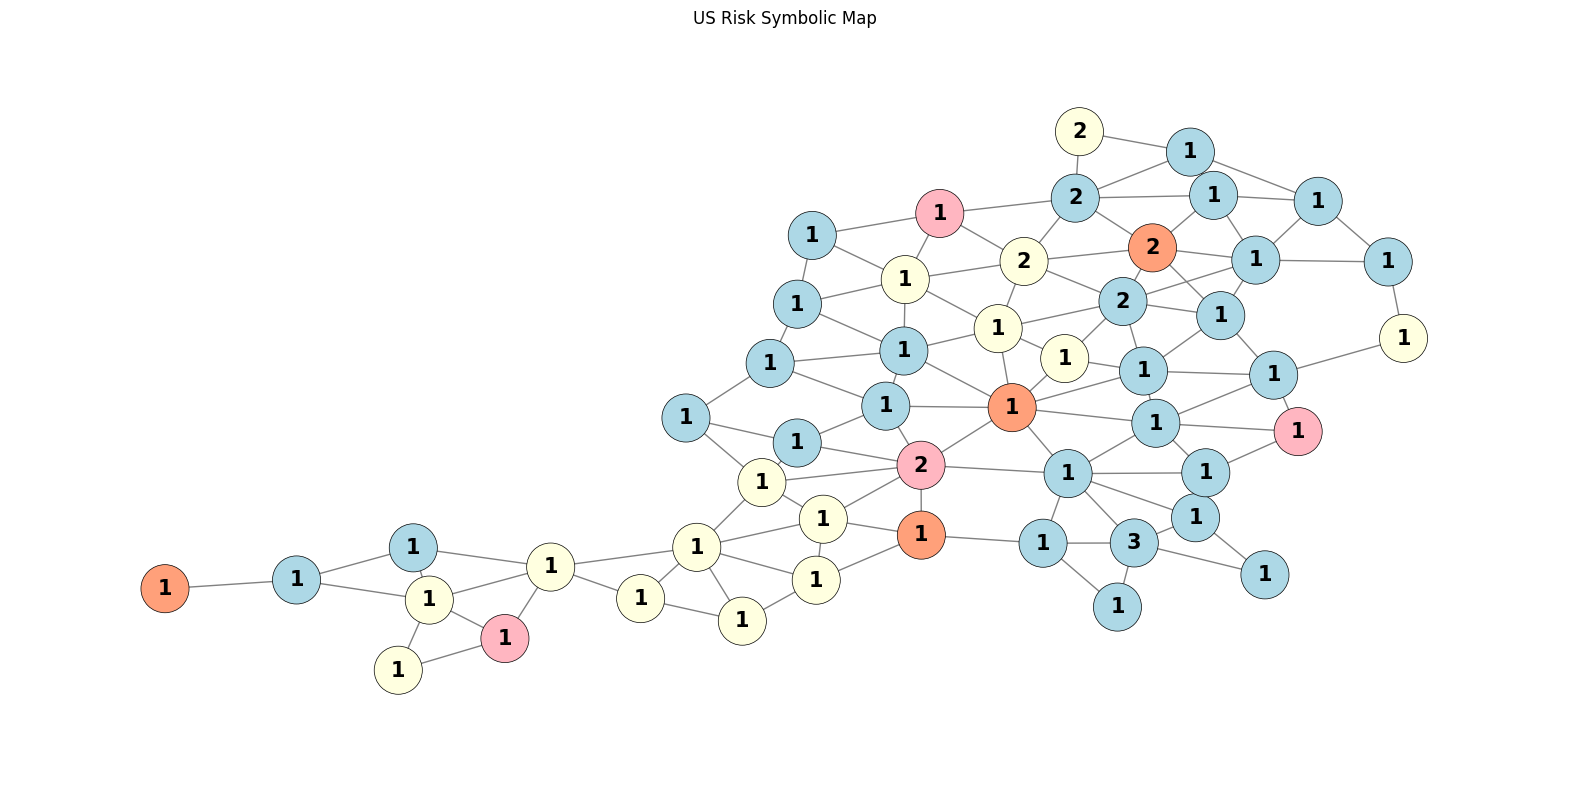

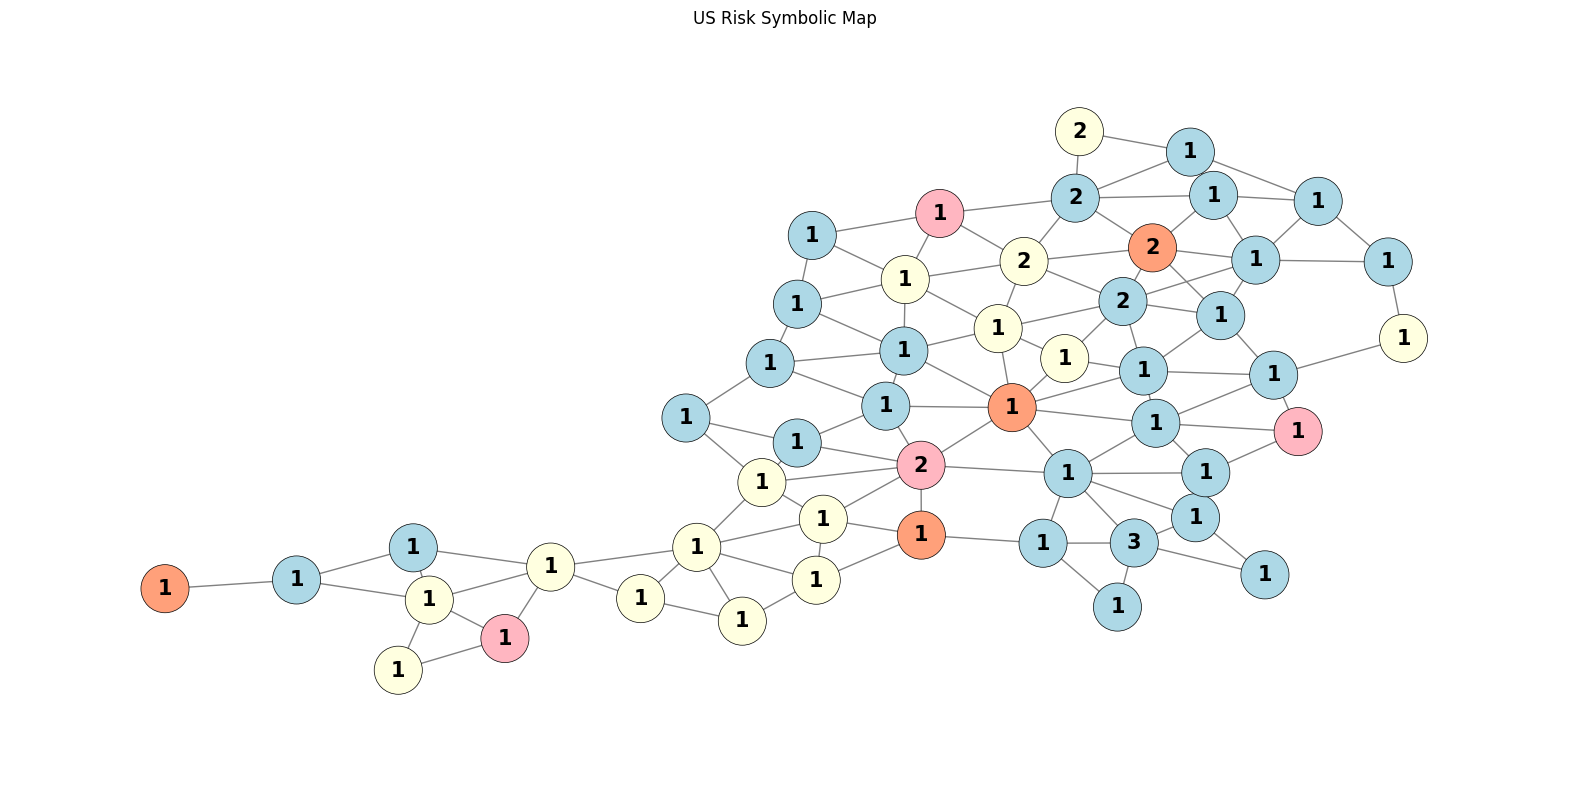

In [122]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


def get_owner_and_troops(state_data):
    owner_and_troops = {}
    
    for player, territories in state_data.items():
        for territory, troops in territories.items():
            owner_and_troops[territory] = {'owner': player, 'troops': troops}
    
    return owner_and_troops


def augment_graph_with_state(G, state_data):
    # Define color mapping for players
 
    player_colors = {
        -1: 'gray',  # Neutral color
        0: 'blue',   # Customize player 0's color (adjust as needed)
        1: 'red',    # Customize player 1's color (adjust as needed)
        # Add more player colors as needed
    }

    # Initialize node colors and labels
    node_colors = []
    node_labels = {}

    # Iterate over nodes in the graph
    for node in G.nodes():
        player = state_data.get(node, -1)  # Default to neutral color if not found in state data
        print(player)
        color = player_colors.get(player, 'gray')  # Get player color, default to gray if not found
        troops = state_data[node] if player != -1 else 0  # Troops count (0 for neutral)

        # Assign the color to nodes and label with troops
        node_colors.append(color)
        node_labels[node] = troops

    return node_colors, node_labels


def risk_graph(game, player_colors=PLAYER_COLORS):
    owner_and_troops = get_owner_and_troops(game.json()['state'])
    terr_to_id = {}
    id_to_terr = []
    for i, terr in enumerate(game.json()['territories']):
        terr_to_id[terr['name']] = i
        id_to_terr.append(terr['name'])

    territory_neighbors = {}
    for i, terr in enumerate(game.json()['territories']):
        nei = [terr_to_id[adj_terr] for adj_terr in terr['adjacent_territories']]
        territory_neighbors[i] = nei
    # Create a graph
    G = nx.Graph()

    # Add edges based on your data
    for node, edges in territory_neighbors.items():
        for edge in edges:
            G.add_edge(node, edge)

    node_colors = []
    node_labels = {}  # Initialize a dictionary for node labels

    for node in G.nodes():
        terr_name = id_to_terr[node]
        owner_and_n_troops = owner_and_troops[terr_name]
        owner = owner_and_n_troops['owner']
        n_troops = owner_and_n_troops['troops']
        node_colors.append(player_colors[owner])
        node_labels[node] = str(n_troops)
        G.nodes[node]['owner'] = owner

    # Use a different layout algorithm (e.g., Kamada-Kawai)
    pos = nx.kamada_kawai_layout(G)

    # Customize node and edge attributes for better visualization
    node_options = {
        "node_color": "skyblue",
        "node_size": 1200,
        "linewidths": 0.5,
        "edgecolors": "black",
        "node_color": node_colors,
        #"labels": node_labels
    }
    edge_options = {
        "width": 1.0,
        "edge_color": "gray",
    }

    # Create a plot and axis object
    fig, ax = plt.subplots(figsize=(20, 10))

    # Draw nodes and edges on the specified axis
    nx.draw_networkx_nodes(G, pos, ax=ax, **node_options)
    nx.draw_networkx_edges(G, pos, ax=ax, **edge_options)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=15, font_color="black", font_weight="bold", ax=ax)

    # Adjust the plot limits for a better view
    ax.set_xlim(-1.2, 0.8)
    ax.set_ylim(-1, 1)

    ax.set_title("US Risk Symbolic Map")
    ax.axis("off")  # Turn off axis
    
    # Return both the graph object and the axis object
    return G, fig, player_colors


from copy import deepcopy


def step(game):
    current_player = game.player_turn
    game.players[current_player].get_minimax_move(game)


def simulate(game, num_of_simulations=10, step=True, plot=True, player_colors=PLAYER_COLORS, depth=1):
    simulation_results = {}

    current_player = game.player_turn
    playing_player = current_player
    if plot:
        G, fig, player_colors = risk_graph(game)
    game_cahce = deepcopy(game)
    turn_utilities = []

    for i in range(num_of_simulations):
        print(f'simulation {i}')
        for d in range(depth):
            print(f'compute for depth {d}')
            if game.players[current_player] is None:
                continue
            print(f'{player_colors[game.player_turn]} plays!')
            
            game.players[current_player].get_minimax_move(game)
            # In the last one we step
            print(len(game.players[current_player].agent.all_utilities_ls[:]))
            turn_utilities += game.players[current_player].agent.all_utilities_ls[:]
            print(len(turn_utilities))
        if i != num_of_simulations-1 or not step:
            game = deepcopy(game_cahce)
        
    for utilities in turn_utilities:
        for k, ls in utilities.items():
            if k not in simulation_results:
                simulation_results[k] = []
            simulation_results[k] += ls
        #print(game.players[current_player].agent.all_utilities_ls)
    res_df = pd.DataFrame(simulation_results)
    res_df.rename(columns=player_colors, inplace=True)
    player_corr = res_df.corr().loc[player_colors[playing_player]]

    game.players[playing_player].agent.all_utilities_ls = []
    return playing_player, player_corr


G, _, _ = risk_graph(game=game)
shared_edges = remove_duplicates_from_dict(count_edges_between_owners(G=G), filter_by_player=game.player_turn)
playing_player, player_corr = simulate(game=game, num_of_simulations=5, depth=len(game.players))
print(f'correlation for player {PLAYER_COLORS[playing_player]}')
print(player_corr)
agreement = \
    calculate_and_sort_spearman_corr(get_edges_df(PLAYER_COLORS[playing_player], shared_edges), player_corr[player_corr.index != PLAYER_COLORS[playing_player]])
print(agreement)
# -1: 'lightgray',  # Light gray for neutral
# 0: 'lightblue',   
# 1: 'lightpink', 
# 2: 'lightgreen',
# 3: 'lightyellow',
# 4: 'lightsalmon',
# 5: 'lightcoral',
# 6: 'lightcyan',    # Light cyan for player 6
# 7: 'mediumpurple',    # Light pink for player 7

In [90]:
player_corr

lightblue      1.000000
lightpink     -0.787981
lightgreen    -0.434917
lightyellow   -0.905544
lightsalmon   -0.425801
Name: lightblue, dtype: float64

-0.7929050101030399

In [112]:
get_edges_df(PLAYER_COLORS[playing_player], shared_edges)

lightyellow    13
lightgreen      4
lightpink       8
lightsalmon     8
dtype: int64

In [113]:
player_corr[player_corr.index != PLAYER_COLORS[playing_player]]

lightpink     -0.787981
lightgreen    -0.434917
lightyellow   -0.905544
lightsalmon   -0.425801
Name: lightblue, dtype: float64

In [94]:
playing_player

0

In [34]:
def step(game):
    current_player = game.player_turn
    game.players[current_player].get_minimax_move(game)

for _ in range(10):
    step(game=game)

{'move_type': 'reinforce', 'territory': 'Pennsylvania', 'troops': 9}
{0: -0.1367471632318077, 1: -0.059277781342958864, 2: -0.6307092004788111, 4: 0.0}
{'move_type': 'attack', 'attacking': 'Pennsylvania', 'troops': 9, 'attacked': 'Ohio', 'attacked_player': 0, 'won': 1, 'probability': 0.03106666666666667}
DICE: [5, 3, 2] [6, 5, 2]
DICE: [5, 5, 1] [6, 6, 2]
DICE: [4, 3, 2] [4, 4, 4]
{'move_type': 'reinforce', 'territory': 'Utah', 'troops': 3}
{0: -0.47118007493012837, 1: -0.26902264297854883, 2: -0.44821970117482274, 3: -0.40612355761185953}
{'move_type': 'attack', 'attacking': 'Utah', 'troops': 4, 'attacked': 'Idaho', 'attacked_player': 2, 'won': 1, 'probability': 0.10355555555555557}
DICE: [4, 2, 1] [4, 2, 1]
DICE: [5] [3]

ONLY CHILD TO ROOT NODE  {'move_type': 'end_turn'}
{0: nan, 1: nan, 2: nan, 3: nan}
{'move_type': 'reinforce', 'territory': 'Arizona', 'troops': 3}
{1: -0.6053276279615319, 2: -0.3194000324008054, 3: -0.28989737709949975, 4: -0.2131663939419114}
{'move_type': 'attac

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


{1: -0.6956986033786794, 2: -0.21272197096765846, 3: -0.3586719907598572, 4: -0.16918997941979627}
{'move_type': 'attack', 'attacking': 'Oregon', 'troops': 1, 'attacked': 'Idaho', 'attacked_player': 4, 'won': 0, 'probability': 0.233}
DICE: [5] [3]
{1: -0.8884803732858293, 2: 0.11719134468878442, 3: 0.19656023485326135, 4: 1.0708303456256839e-15}
{'move_type': 'attack', 'attacking': 'Indiana', 'troops': 1, 'attacked': 'Illinois', 'attacked_player': 1, 'won': 0, 'probability': 0.233}
DICE: [2] [4]

ONLY CHILD TO ROOT NODE  {'move_type': 'end_turn'}
{1: -0.843325571030432, 2: 0.26075908093689737, 3: 0.39207660371086944, 4: nan}


/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


{'move_type': 'reinforce', 'territory': 'Wyoming', 'troops': 3}
{0: -0.22057441745215148, 2: -0.19451681323659584, 3: -0.717623951718278, 4: -0.2814546927955799}
{'move_type': 'attack', 'attacking': 'Wyoming', 'troops': 3, 'attacked': 'Montana', 'attacked_player': 3, 'won': 1, 'probability': 0.15533333333333335}
DICE: [6, 3, 1] [5, 5, 1]
{0: -0.18987169895134526, 2: -0.04237241278111252, 3: -0.7144936640983209, 4: -0.04237241278111252}
{'move_type': 'attack', 'attacking': 'Montana', 'troops': 2, 'attacked': 'Idaho', 'attacked_player': 0, 'won': 1, 'probability': 0.233}
DICE: [5, 2] [3, 3]
{0: -0.35263901767955963, 2: -0.3526390176795596, 3: -0.5618973358630346, 4: -0.28288624495173487}
{'move_type': 'attack', 'attacking': 'Idaho', 'troops': 1, 'attacked': 'Washington', 'attacked_player': 3, 'won': 0, 'probability': 0.233}
DICE: [5] [1]

ONLY CHILD TO ROOT NODE  {'move_type': 'end_turn'}
{0: nan, 2: nan, 3: nan, 4: nan}
{'move_type': 'reinforce', 'territory': 'Nevada', 'troops': 3}
{0: 

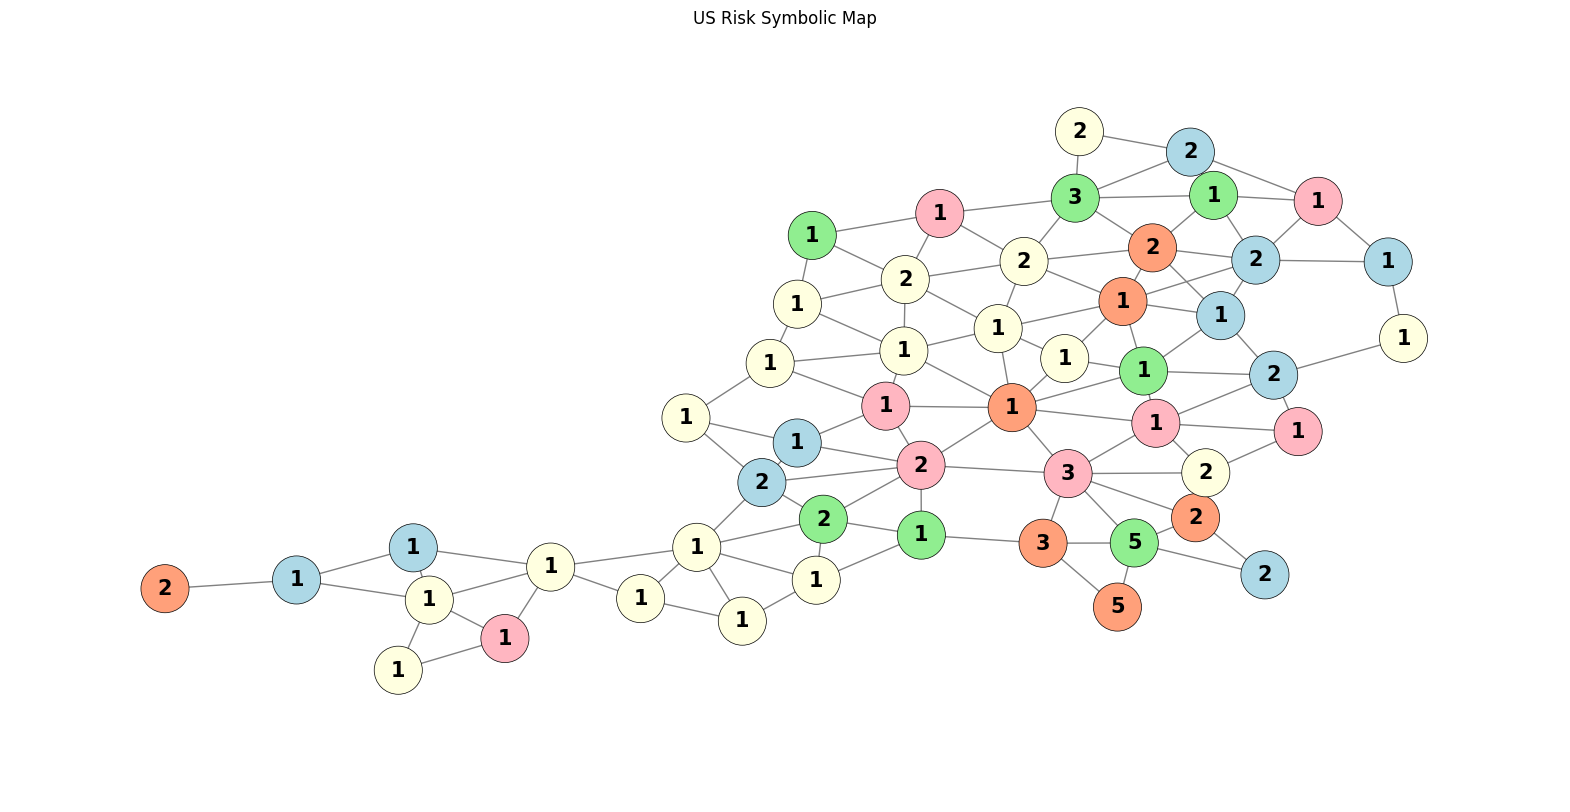

In [67]:
G, _, _ = risk_graph(game=game)

{('lightsalmon', 'lightyellow'): 8,
 ('lightpink', 'lightsalmon'): 6,
 ('lightblue', 'lightsalmon'): 6,
 ('lightgreen', 'lightsalmon'): 8,
 ('lightpink', 'lightyellow'): 10,
 ('lightgreen', 'lightpink'): 7,
 ('lightblue', 'lightgreen'): 7,
 ('lightblue', 'lightyellow'): 9,
 ('lightblue', 'lightpink'): 8,
 ('lightgreen', 'lightyellow'): 8}

In [68]:
node_owner = nx.get_node_attributes(G, 'owner')
node_owner
#list(G.nodes())

{0: 4,
 23: 3,
 41: 1,
 8: 0,
 9: 2,
 1: 0,
 10: 3,
 4: 1,
 2: 0,
 27: 2,
 43: 4,
 30: 0,
 5: 4,
 3: 1,
 24: 4,
 35: 2,
 17: 1,
 42: 0,
 49: 3,
 26: 3,
 15: 3,
 6: 1,
 31: 3,
 38: 3,
 20: 3,
 7: 3,
 29: 3,
 19: 3,
 37: 3,
 39: 4,
 32: 4,
 11: 2,
 25: 1,
 46: 3,
 36: 0,
 12: 1,
 48: 3,
 14: 3,
 13: 0,
 16: 1,
 21: 3,
 34: 0,
 22: 3,
 40: 3,
 45: 2,
 47: 2,
 18: 4,
 28: 0,
 44: 0,
 33: 2}

Explaining actions:

To explain the influence of an attack, we can compute P(attack|success)*utility_for_agents(attack|success) + P(attack|failute)*utility_for_agents(attack|failure)

In [23]:
simulation_results

{}

 {-1: 'lightgray',
  0: 'lightblue',
  1: 'lightpink',
  2: 'lightgreen',
  3: 'lightyellow',
  4: 'lightsalmon',
  5: 'lightcoral',
  6: 'lightcyan',
  7: 'mediumpurple'}

In [12]:
import pandas as pd


pd.DataFrame(simulation_results).corr().iloc[current_player]

0   -0.385405
1    1.000000
2   -0.464662
Name: 1, dtype: float64

In [34]:
current_player

1

(<networkx.classes.graph.Graph at 0x7fd51e977cd0>,
 <Figure size 2000x1000 with 1 Axes>,
 {-1: 'lightgray',
  0: 'lightblue',
  1: 'lightpink',
  2: 'lightgreen',
  3: 'lightyellow',
  4: 'lightsalmon',
  5: 'lightcoral',
  6: 'lightcyan',
  7: 'mediumpurple'})

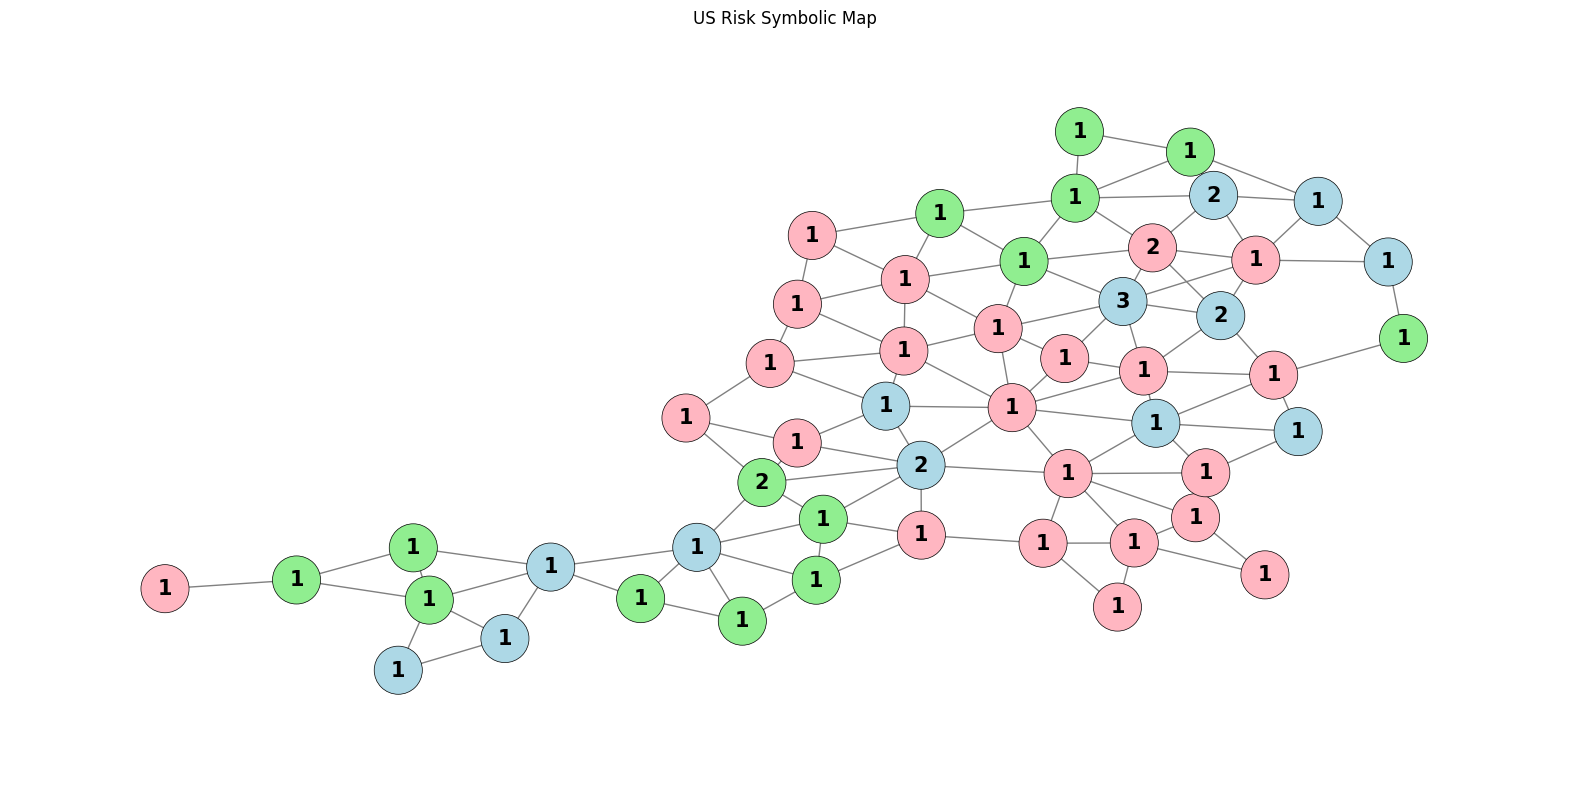

In [16]:
risk_graph(game)

In [7]:
for i, terr in enumerate(game.json()['territories']):
    print(terr)
    player = terr['occupying_player']
    
    break

{'name': 'Alabama', 'adjacent_territories': ['Mississippi', 'Tennessee', 'Florida', 'Georgia'], 'occupying_player': 0, 'troops': [{'id': 2, 'territory': 'Alabama', 'player': 0, 'value': 2}]}


In [68]:
all_states_risk = set([v for vals in game.json()['state'].values() for v in vals])

In [123]:
all_states_risk

{'Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming'}

In [69]:
territory_neighbors

{0: [23, 41, 8, 9],
 1: [10, 4, 2],
 2: [4, 27, 43, 30, 5],
 3: [41, 24, 35, 23, 17, 42],
 4: [27, 2, 1],
 5: [43, 49, 2, 30, 26, 15, 35],
 6: [31, 38, 20],
 7: [29, 19, 37],
 8: [0, 9],
 9: [8, 0, 39, 41, 32],
 10: [1, 42],
 11: [49, 25, 46, 43, 27, 36],
 12: [48, 14, 24, 13, 16],
 13: [12, 21, 34, 16],
 14: [48, 22, 26, 40, 24, 12],
 15: [26, 35, 5, 24],
 16: [13, 12, 45, 34, 47, 41, 24],
 17: [3, 42, 23],
 18: [28],
 19: [7, 45, 37, 47],
 20: [44, 28, 31, 38, 6],
 21: [13, 34, 48],
 22: [33, 40, 14, 48],
 23: [0, 3, 17, 41],
 24: [15, 3, 14, 12, 16, 41, 35],
 25: [11, 49, 33, 40],
 26: [14, 40, 49, 5, 15, 24],
 27: [11, 43, 2, 4, 36],
 28: [18, 44, 20],
 29: [7, 31, 37],
 30: [35, 42, 5, 43, 2],
 31: [44, 29, 37, 20, 6],
 32: [39, 45, 41],
 33: [25, 40, 22],
 34: [47, 13, 21, 16, 37],
 35: [42, 15, 5, 30, 3, 24],
 36: [11, 46, 27, 4],
 37: [31, 7, 29, 19, 34, 47],
 38: [20, 6],
 39: [32, 9],
 40: [33, 49, 25, 26, 14, 22],
 41: [32, 0, 23, 9, 3, 16, 24],
 42: [30, 35, 3, 17, 10],
 43

In [96]:
# https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

path = './us_map/tl_2020_us_state.shp'
df = gpd.read_file(path)
df = df.to_crs("EPSG:4326")

In [114]:
len(df[df['NAME'].apply(lambda x: x in all_states_risk)])

50

In [158]:
len(all_states_risk)

50

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/tmp/ipykernel_2759496/992066680.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us49['centroid'] = us49.centroid


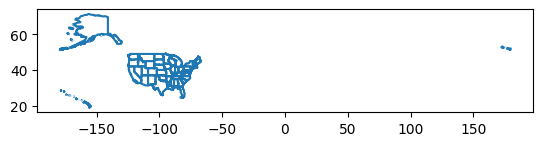

In [169]:
from shapely.geometry import Point

non_continental = ['VI','MP','GU','PR']#'HI','AS''AK',
us49 = df.copy()
us49 = df[df['NAME'].apply(lambda x: x in all_states_risk)]
for n in non_continental:
    us49 = us49[us49.STUSPS != n]


us49.boundary.plot()
us49['centroid'] = us49.centroid


# New centroid coordinates for Hawaii
new_hawaii_centroid = Point(-130, 35)  # Replace with the desired new coordinates for Hawaii

# New centroid coordinates for Alaska
new_alaska_centroid = Point(-130, 50)  # Replace with the desired new coordinates for Alaska

# Update the geometry of Hawaii (assuming 'NAME' column contains state names)
us49.loc[us49['NAME'] == 'Hawaii', 'centroid'] = new_hawaii_centroid

# Update the geometry of Alaska
us49.loc[us49['NAME'] == 'Alaska', 'centroid'] = new_alaska_centroid


us49 = us49.reset_index()

plt.show()

In [112]:
us49['centroid'].apply(lambda x: x.x).max()

-69.20275870596267

In [135]:
len(us49)

50

In [136]:
len(us49['centroid'])

50

In [171]:
for i in range(len(us49)):
    if i % 2 == 0:
        us49.at[i, 'owner'] = 0
    elif i % 3 == 0:
        us49.at[i, 'owner'] = 1
    elif i % 5 == 0:
        us49.at[i, 'owner'] = 3
    else:
        us49.at[i, 'owner'] = 4

In [172]:
us49['owner'].unique()

array([0., 4., 1., 3.])

In [173]:
len(us49['centroid'])

50

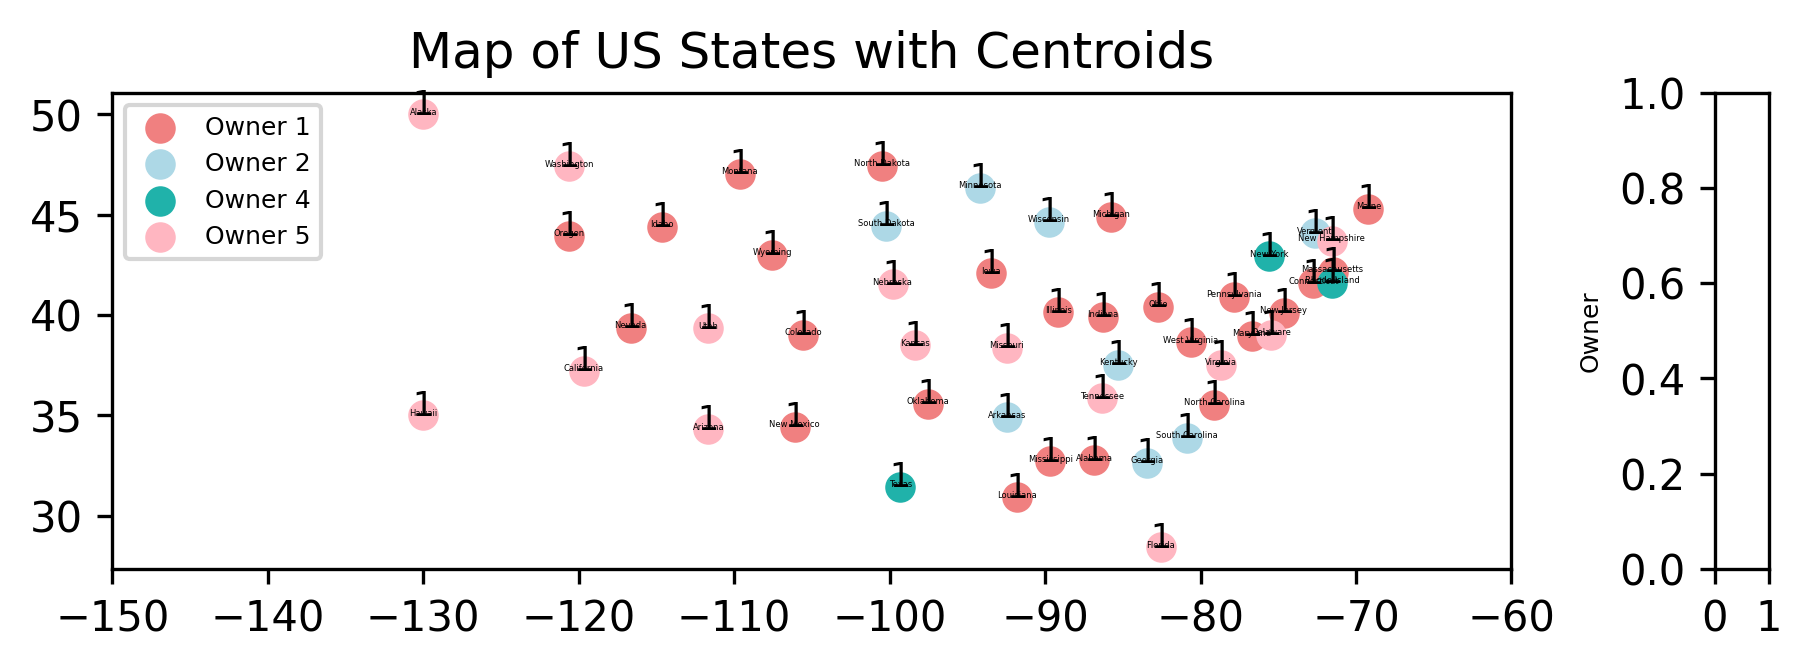

In [176]:
# Assuming you have a GeoDataFrame of US states called 'us49' with an 'owner' column containing values 1 to 7.

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0, alpha=0.5)

# Replace 'owner' with the name of the column you want to use
plt.ylabel('Owner', fontsize=6)

# Define a list of 7 predefined colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightseagreen', 'lightpink', 'lightcyan', 'lavender']

#us49.plot(ax=ax, alpha=0.8, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1,label='Inline label')

# Iterate through colors and plot centroids with a different color if there are points
for i, color in enumerate(colors):
    subset = us49[us49['owner'] == i]  # Assuming owner values are 1 to 7
    if not subset.empty:
        subset['centroid'].plot(ax=ax, marker='o', color=color, markersize=40, label=f'Owner {i + 1}')

for i in range(len(us49['centroid'])):
    centroid = us49['centroid'].iloc[i]
    ax.annotate("1", xy=(centroid.x, centroid.y), fontsize=8, ha='center')
    ax.annotate(us49['NAME'].iloc[i], xy=(centroid.x, centroid.y), fontsize=2, ha='center')
ax.set_xlim(-150, -60)
# Add a legend
ax.legend(fontsize=6)
plt.show()

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import cycle

# Assuming you have a GeoDataFrame of US states called 'us49' with an 'owner' column containing values 1 to 7.

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0, alpha=0.5)

# Replace 'owner' with the name of the column you want to use
plt.ylabel('Owner', fontsize=6)

# Define a list of 7 predefined colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']

# Create a cycle of the 7 colors
color_cycle = cycle(colors)

# Plot the centroids with colors based on the 'owner' column
for owner_value in range(1, 8):
    subset = us49[us49['owner'] == owner_value]
    color = next(color_cycle)  # Get the next color from the cycle
    subset['centroid'].plot(ax=ax, marker='o', color=color, markersize=100, label=f'Owner {owner_value}')

# Add a legend
ax.legend(fontsize=6)

plt.show()


/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


ValueError: cannot convert float NaN to integer

<Figure size 2400x2400 with 2 Axes>

In [175]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming you have a GeoDataFrame of US states called 'us49' with an 'owner' column containing values 1 to 7 and possibly NaN.

# Define a list of 7 colors for the 7 possible values
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink']

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0, alpha=0.5)

# Replace 'owner' with the name of the column you want to use
plt.ylabel('owner', fontsize=6)

# Fill NaN values in the 'owner' column with a default value, e.g., 0
us49['owner'].fillna(0, inplace=True)

# Plot the centroids with colors based on the 'owner' column values (1 to 7)
for i in range(1, 8):
    subset = us49[us49['owner'] == i]
    color = colors[i - 1]  # Assign a color from the list
    subset['centroid'].plot(ax=ax, marker='o', color=color, markersize=100, label=f'Owner {i}')

# Add a legend
ax.legend(fontsize=6)

plt.show()


/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


ValueError: cannot convert float NaN to integer

<Figure size 2400x2400 with 2 Axes>

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


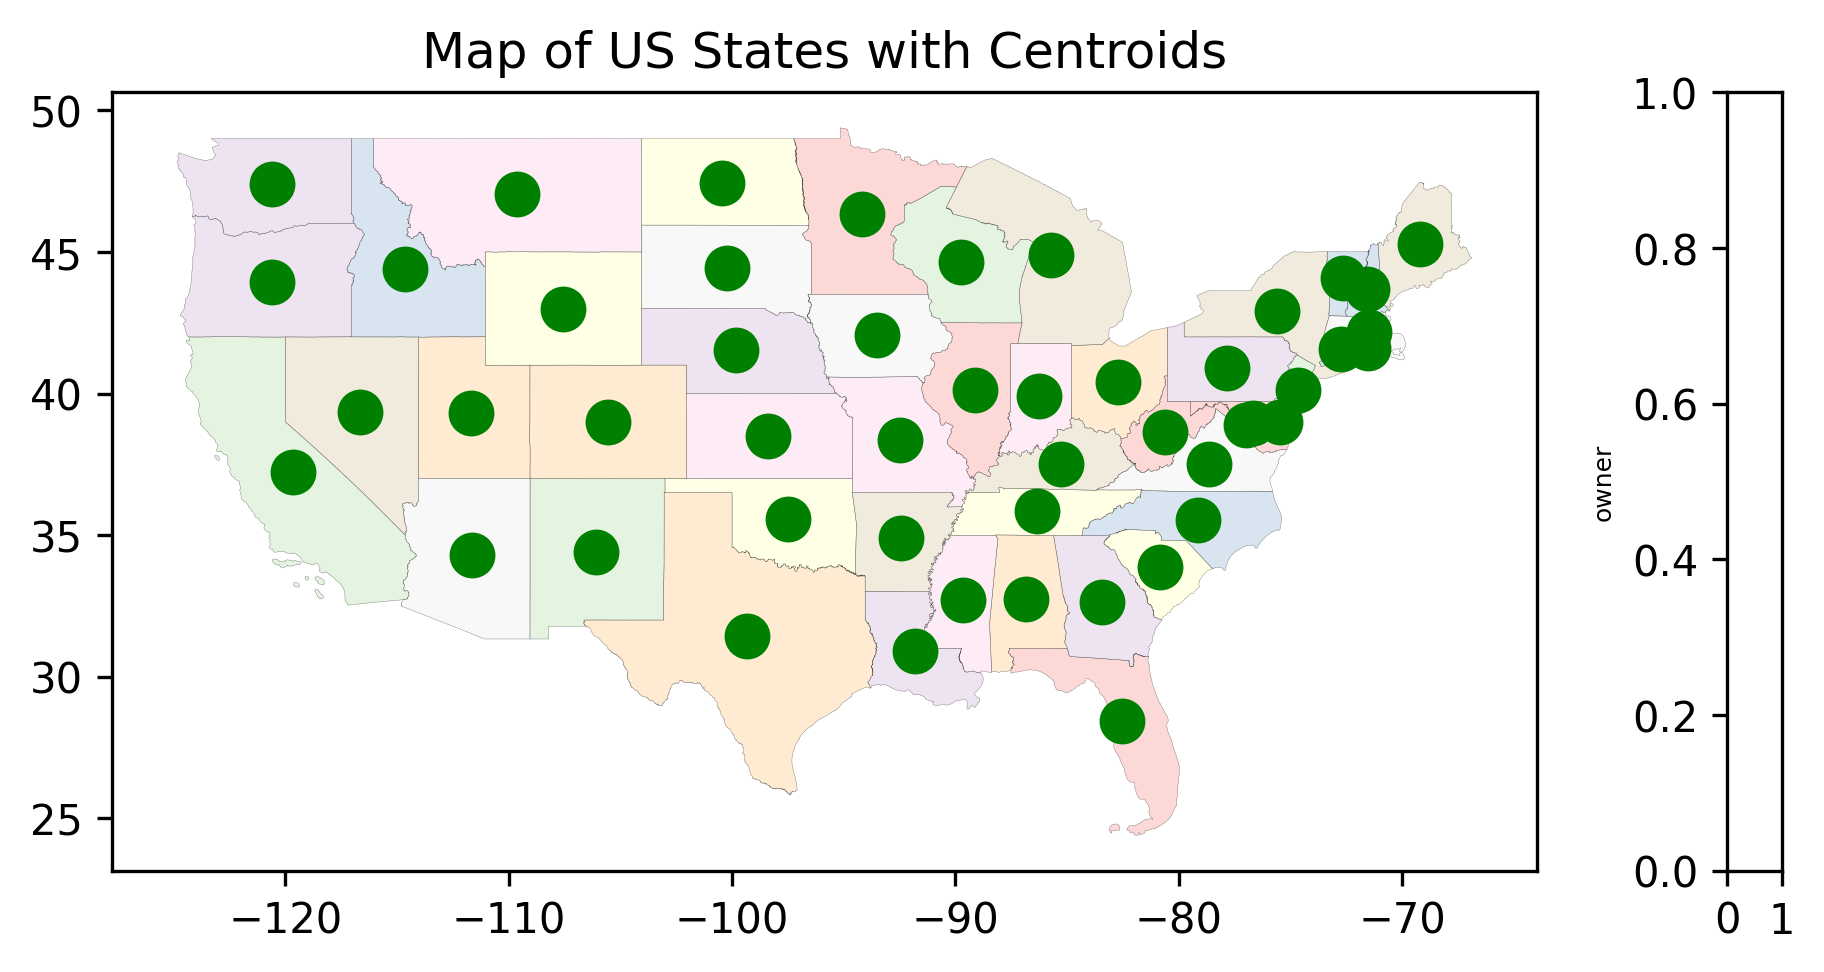

In [88]:

f,ax = plt.subplots(1,1, figsize=(8,8), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot(ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1,label='Inline label')
plt.ylabel('owner', fontsize=6)
us49['centroid'].plot(ax=ax, marker='o', color='green', markersize=100)

plt.show()

In [54]:
us49.columns

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME',
       'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


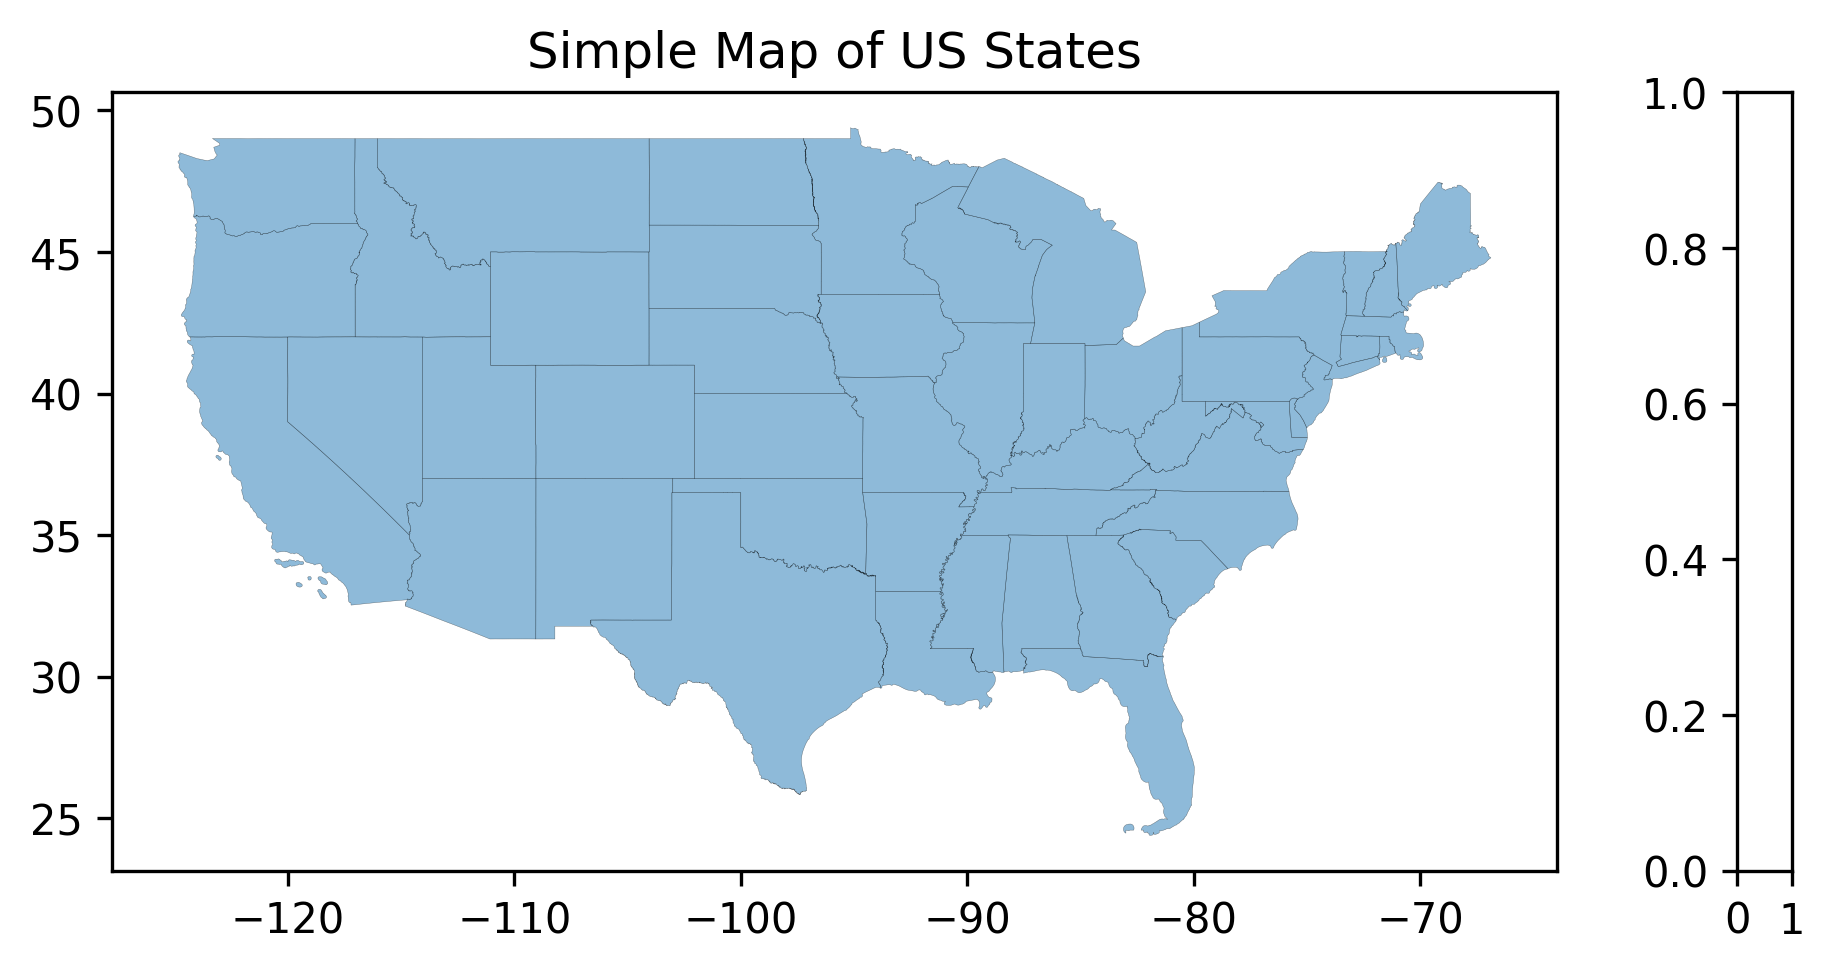

In [44]:
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Simple Map of US States')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot(ax=ax, alpha=0.5, edgecolor='k', legend=True, cax=cax, linewidth=0.1)
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

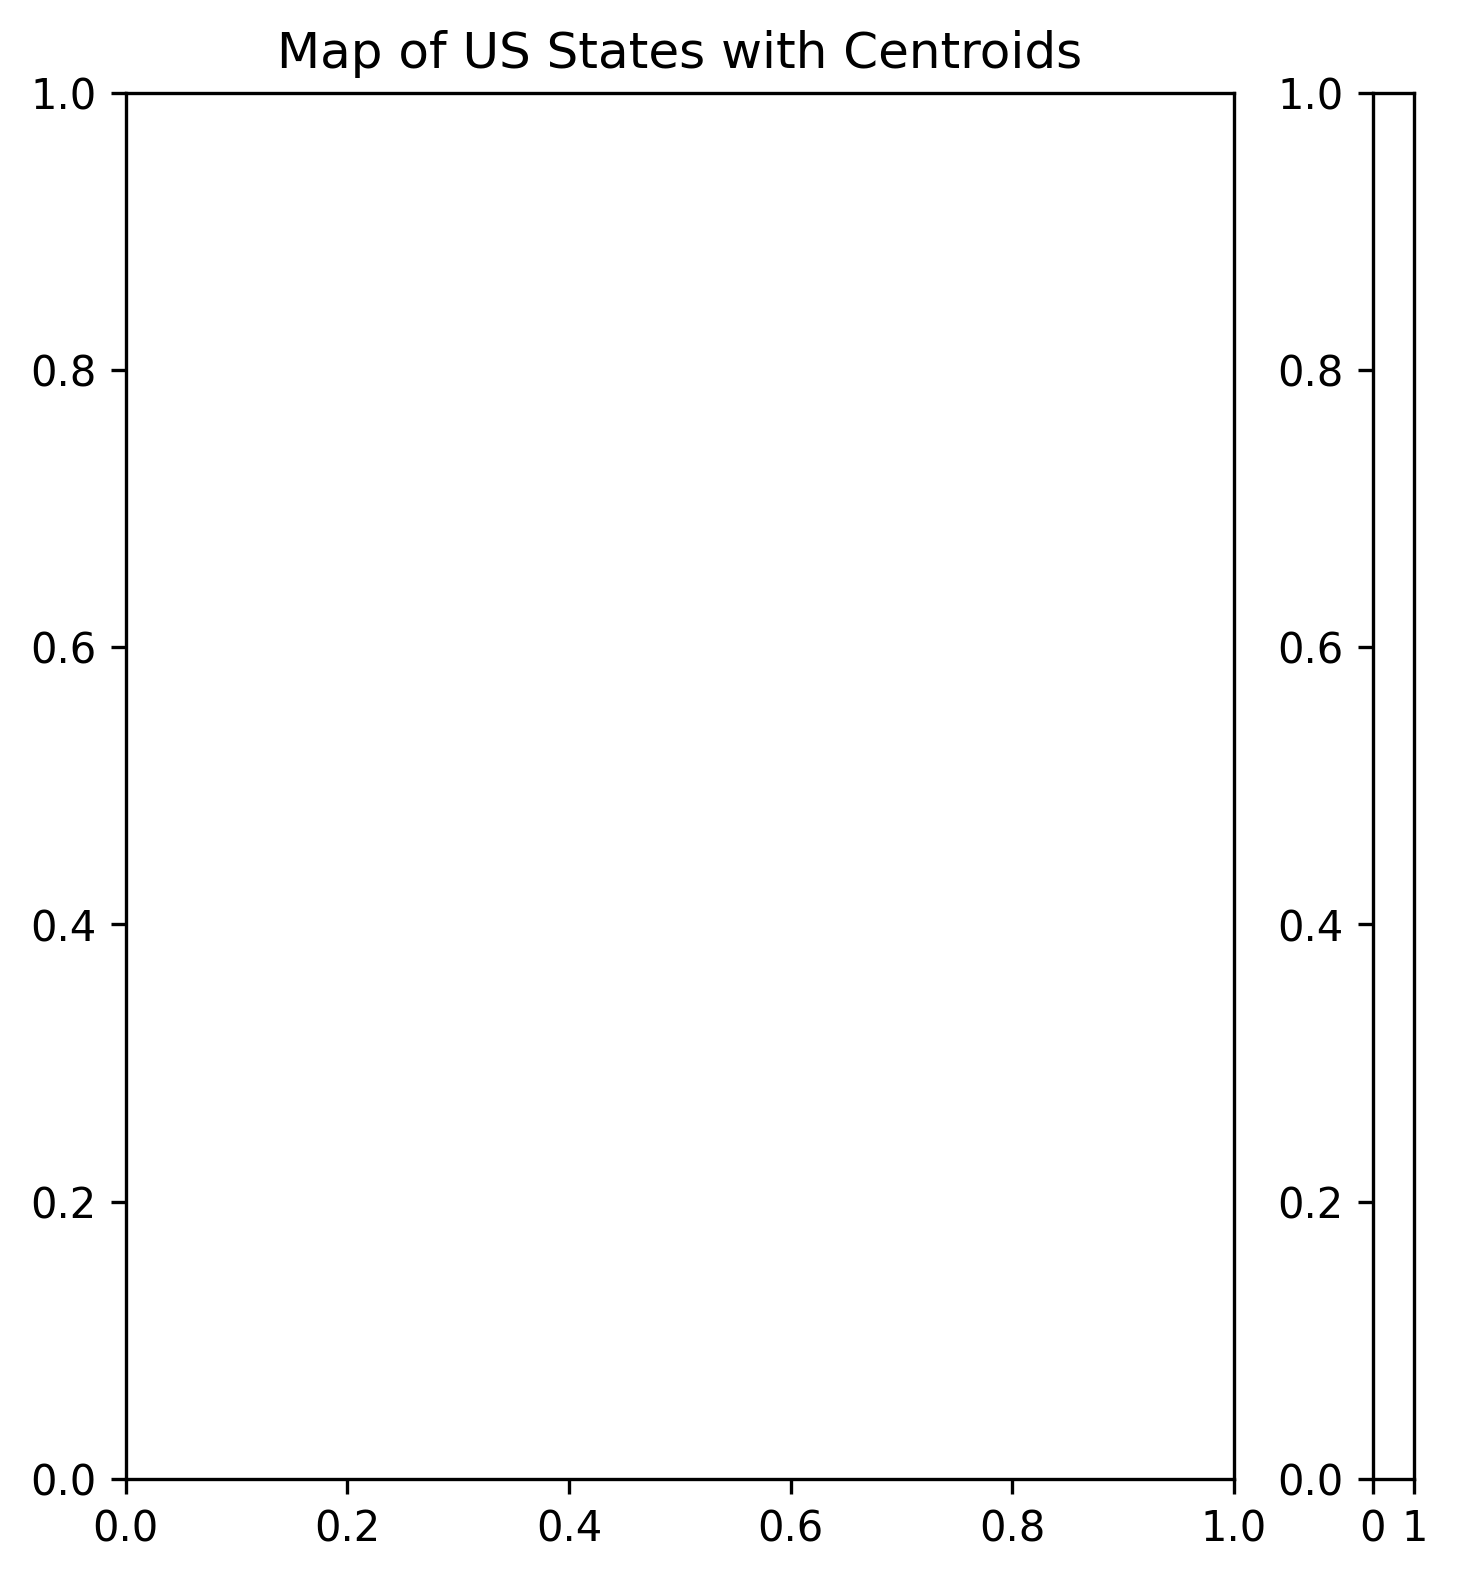

In [47]:
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Map of US States with Centroids')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot('ALAND_miles', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1,label='Inline label')
plt.ylabel('Square miles', fontsize=6)
us49['centroid'].plot(ax=ax, marker='o', color='red', markersize=5)
plt.show()

/home/maayan/anaconda3/envs/research/lib/python3.8/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


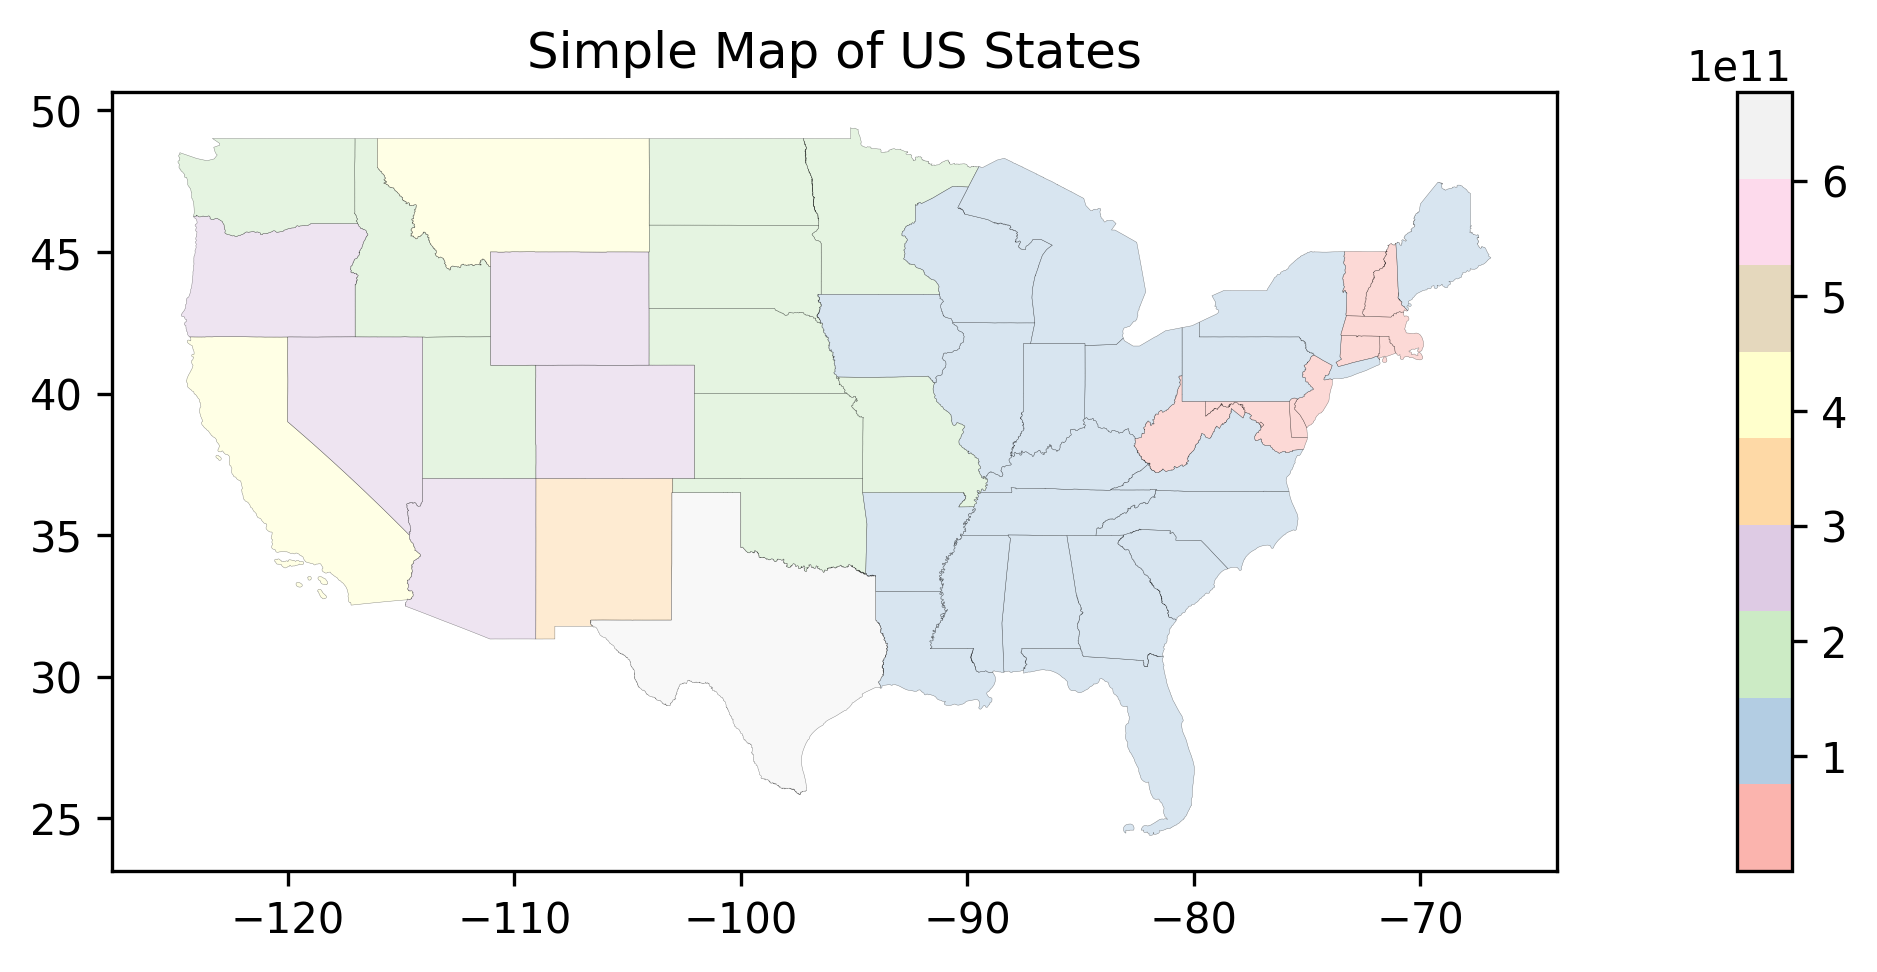

In [32]:
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Simple Map of US States')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot('ALAND', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1)
plt.show()

In [156]:
territory_neighbors

{0: [23, 41, 8, 9],
 1: [10, 4, 2],
 2: [4, 27, 43, 30, 5],
 3: [41, 24, 35, 23, 17, 42],
 4: [27, 2, 1],
 5: [43, 49, 2, 30, 26, 15, 35],
 6: [31, 38, 20],
 7: [29, 19, 37],
 8: [0, 9],
 9: [8, 0, 39, 41, 32],
 10: [1, 42],
 11: [49, 25, 46, 43, 27, 36],
 12: [48, 14, 24, 13, 16],
 13: [12, 21, 34, 16],
 14: [48, 22, 26, 40, 24, 12],
 15: [26, 35, 5, 24],
 16: [13, 12, 45, 34, 47, 41, 24],
 17: [3, 42, 23],
 18: [28],
 19: [7, 45, 37, 47],
 20: [44, 28, 31, 38, 6],
 21: [13, 34, 48],
 22: [33, 40, 14, 48],
 23: [0, 3, 17, 41],
 24: [15, 3, 14, 12, 16, 41, 35],
 25: [11, 49, 33, 40],
 26: [14, 40, 49, 5, 15, 24],
 27: [11, 43, 2, 4, 36],
 28: [18, 44, 20],
 29: [7, 31, 37],
 30: [35, 42, 5, 43, 2],
 31: [44, 29, 37, 20, 6],
 32: [39, 45, 41],
 33: [25, 40, 22],
 34: [47, 13, 21, 16, 37],
 35: [42, 15, 5, 30, 3, 24],
 36: [11, 46, 27, 4],
 37: [31, 7, 29, 19, 34, 47],
 38: [20, 6],
 39: [32, 9],
 40: [33, 49, 25, 26, 14, 22],
 41: [32, 0, 23, 9, 3, 16, 24],
 42: [30, 35, 3, 17, 10],
 43

In [177]:
territory_neighbors

{0: [23, 41, 8, 9],
 1: [10, 4, 2],
 2: [4, 27, 43, 30, 5],
 3: [41, 24, 35, 23, 17, 42],
 4: [27, 2, 1],
 5: [43, 49, 2, 30, 26, 15, 35],
 6: [31, 38, 20],
 7: [29, 19, 37],
 8: [0, 9],
 9: [8, 0, 39, 41, 32],
 10: [1, 42],
 11: [49, 25, 46, 43, 27, 36],
 12: [48, 14, 24, 13, 16],
 13: [12, 21, 34, 16],
 14: [48, 22, 26, 40, 24, 12],
 15: [26, 35, 5, 24],
 16: [13, 12, 45, 34, 47, 41, 24],
 17: [3, 42, 23],
 18: [28],
 19: [7, 45, 37, 47],
 20: [44, 28, 31, 38, 6],
 21: [13, 34, 48],
 22: [33, 40, 14, 48],
 23: [0, 3, 17, 41],
 24: [15, 3, 14, 12, 16, 41, 35],
 25: [11, 49, 33, 40],
 26: [14, 40, 49, 5, 15, 24],
 27: [11, 43, 2, 4, 36],
 28: [18, 44, 20],
 29: [7, 31, 37],
 30: [35, 42, 5, 43, 2],
 31: [44, 29, 37, 20, 6],
 32: [39, 45, 41],
 33: [25, 40, 22],
 34: [47, 13, 21, 16, 37],
 35: [42, 15, 5, 30, 3, 24],
 36: [11, 46, 27, 4],
 37: [31, 7, 29, 19, 34, 47],
 38: [20, 6],
 39: [32, 9],
 40: [33, 49, 25, 26, 14, 22],
 41: [32, 0, 23, 9, 3, 16, 24],
 42: [30, 35, 3, 17, 10],
 43

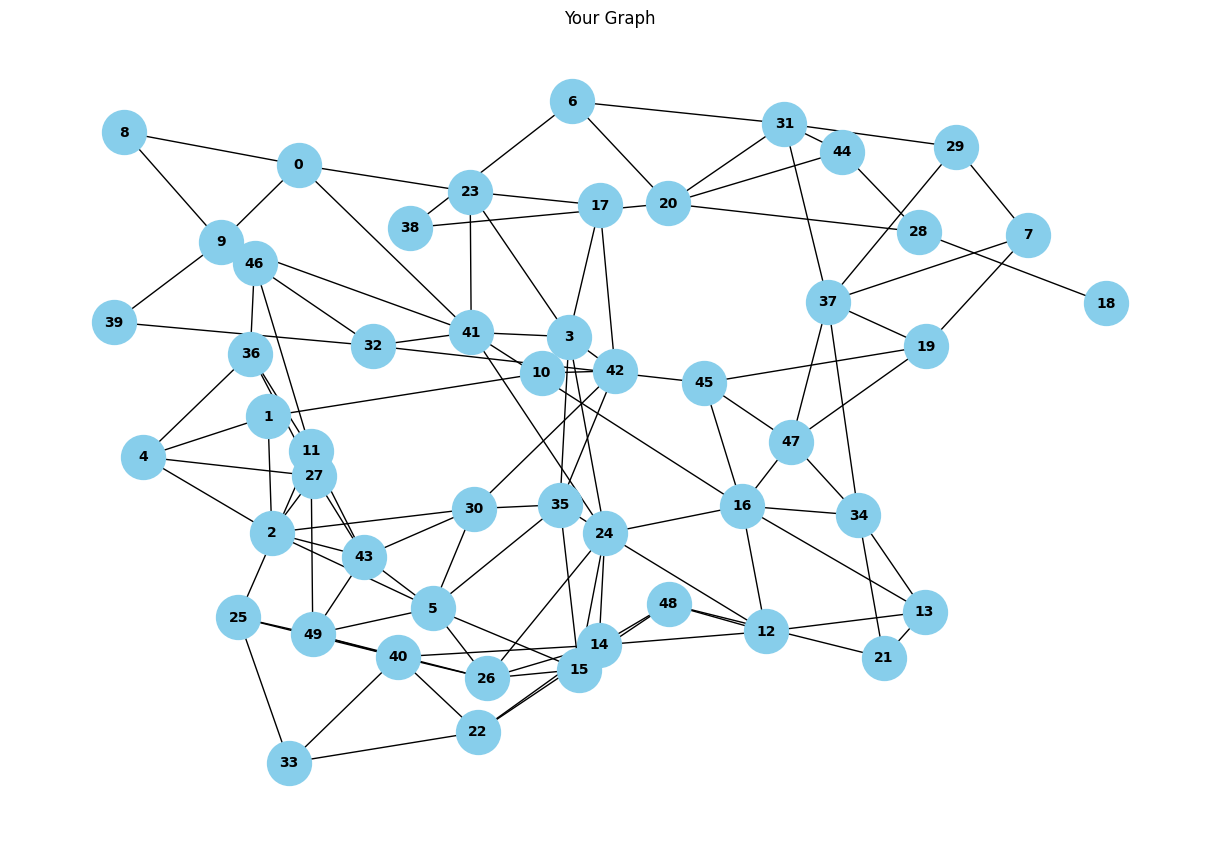

In [180]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph
G = nx.Graph()

# Add edges based on your data
for node, edges in territory_neighbors.items():
    for edge in edges:
        G.add_edge(node, edge)

# Plot the graph
pos = nx.spring_layout(G, seed=42, k=0.5)  # Define the layout for better visualization
plt.figure(figsize=(12, 8))

nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')
plt.title("Your Graph")
plt.show()

In [182]:
territory_neighbors

{0: [23, 41, 8, 9],
 1: [10, 4, 2],
 2: [4, 27, 43, 30, 5],
 3: [41, 24, 35, 23, 17, 42],
 4: [27, 2, 1],
 5: [43, 49, 2, 30, 26, 15, 35],
 6: [31, 38, 20],
 7: [29, 19, 37],
 8: [0, 9],
 9: [8, 0, 39, 41, 32],
 10: [1, 42],
 11: [49, 25, 46, 43, 27, 36],
 12: [48, 14, 24, 13, 16],
 13: [12, 21, 34, 16],
 14: [48, 22, 26, 40, 24, 12],
 15: [26, 35, 5, 24],
 16: [13, 12, 45, 34, 47, 41, 24],
 17: [3, 42, 23],
 18: [28],
 19: [7, 45, 37, 47],
 20: [44, 28, 31, 38, 6],
 21: [13, 34, 48],
 22: [33, 40, 14, 48],
 23: [0, 3, 17, 41],
 24: [15, 3, 14, 12, 16, 41, 35],
 25: [11, 49, 33, 40],
 26: [14, 40, 49, 5, 15, 24],
 27: [11, 43, 2, 4, 36],
 28: [18, 44, 20],
 29: [7, 31, 37],
 30: [35, 42, 5, 43, 2],
 31: [44, 29, 37, 20, 6],
 32: [39, 45, 41],
 33: [25, 40, 22],
 34: [47, 13, 21, 16, 37],
 35: [42, 15, 5, 30, 3, 24],
 36: [11, 46, 27, 4],
 37: [31, 7, 29, 19, 34, 47],
 38: [20, 6],
 39: [32, 9],
 40: [33, 49, 25, 26, 14, 22],
 41: [32, 0, 23, 9, 3, 16, 24],
 42: [30, 35, 3, 17, 10],
 43

(<networkx.classes.graph.Graph at 0x7fca37c77b20>,
 <Figure size 1200x800 with 1 Axes>)

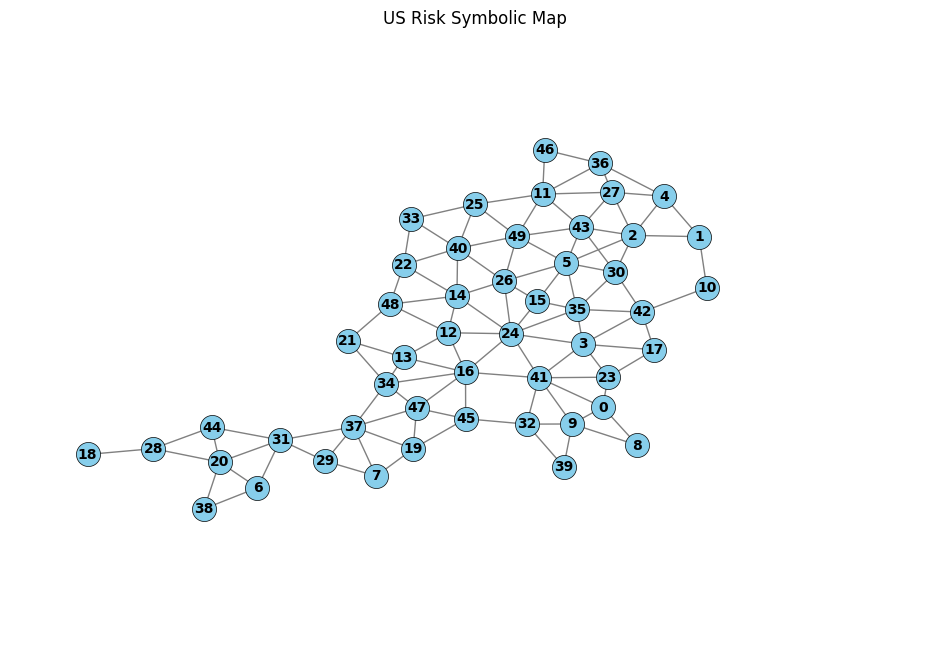

In [37]:
game.json()['territories']

[{'name': 'Alexandria',
  'adjacent_territories': ['Beheira', 'Matruh'],
  'occupying_player': 1,
  'troops': [{'id': 4, 'territory': 'Alexandria', 'player': 1, 'value': 2},
   {'id': 12, 'territory': 'Alexandria', 'player': 1, 'value': 2}]},
 {'name': 'Aswan',
  'adjacent_territories': ['Red Sea', 'Luxor', 'New Valley'],
  'occupying_player': 0,
  'troops': [{'id': 2, 'territory': 'Aswan', 'player': 0, 'value': 2},
   {'id': 10, 'territory': 'Aswan', 'player': 0, 'value': 2},
   {'id': 16, 'territory': 'Aswan', 'player': 0, 'value': 2}]},
 {'name': 'Asyut',
  'adjacent_territories': ['Minya', 'Sohag', 'New Valley', 'Red Sea', 'Qena'],
  'occupying_player': 0,
  'troops': [{'id': 8, 'territory': 'Asyut', 'player': 0, 'value': 2}]},
 {'name': 'Beheira',
  'adjacent_territories': ['Alexandria',
   'Kafr El Sheikh',
   'Gharbia',
   'Monufia',
   'Giza'],
  'occupying_player': 3,
  'troops': [{'id': 0, 'territory': 'Beheira', 'player': 3, 'value': 2},
   {'id': 4, 'territory': 'Beheira', 